# Clustering
Clustering works well when you have cols that are of the same kind of things and /or the same kind of scale

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Create Data:

In [3]:
n_clusters = 6 # number of clusters in generated data
n_samples = 250 # number of samples in each cluster

Generate 6 centroids, then for each centroid generate 250 points around it

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids # create 6 points as (x,y) coords

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
# sample around centroids
def sample(m): 
    # samples n_samples via 2d normal dist with mean(centroids, sigma=diag(5,5))
    return MultivariateNormal(m, torch.diag(tensor([5.,5]))).sample((n_samples,))

In [7]:
sample(centroids[0]).shape

torch.Size([250, 2])

In [8]:
# create datasets
clusters = [sample(c) for c in centroids]
data = torch.cat(clusters)
data.shape

torch.Size([1500, 2])

In [9]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None:
        _, ax = plt.subplots()
        
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]

        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color="m", mew=2)

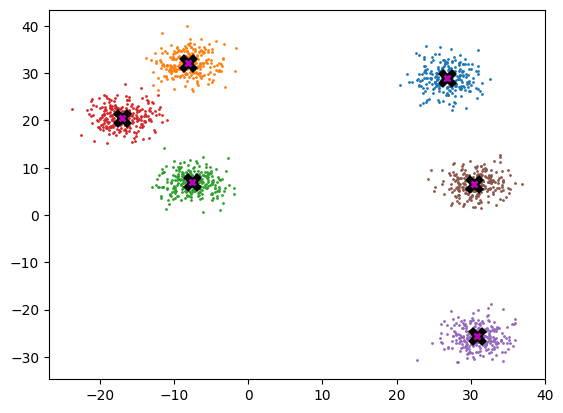

In [10]:
plot_data(centroids, data, n_samples)

In [11]:
'''def plot_data_(centroids, data, n_samples, ax=None):
    for i, centroid in enumerate(centroids):
        # grab data for each cluster from dataset (structure defd above)
        samples = data[i*n_samples:(i+1)*n_samples]

        plt.scatter(samples[:,0], samples[:,1], s=1)
        plt.plot(*centroid, markersize=5, marker="x", color="k", mew=5)
        
plot_data_(centroids, data, n_samples)'''

'def plot_data_(centroids, data, n_samples, ax=None):\n    for i, centroid in enumerate(centroids):\n        # grab data for each cluster from dataset (structure defd above)\n        samples = data[i*n_samples:(i+1)*n_samples]\n\n        plt.scatter(samples[:,0], samples[:,1], s=1)\n        plt.plot(*centroid, markersize=5, marker="x", color="k", mew=5)\n        \nplot_data_(centroids, data, n_samples)'

# Mean Shift
Clustering algorithm that does not require assumption on cluster num. 
It requires a bandiwdth, can be chosen automatically.
It can clusters of any shape (while k-means requires ball shaped clusters).

Algo:
1) for each x in X find dist between x and every other point in X
2) create weights for each point in X using a gaussian kernel of its distance to all other points in X
    - distant points -> low weight, close points -> high weight
    - the rate at which the weights fall to 0 is defd by bandwidth -> std of the gaussian kernel
3) iteratively update weights

In [12]:
def gaussian(d, bw):
    return torch.exp(-.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [13]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

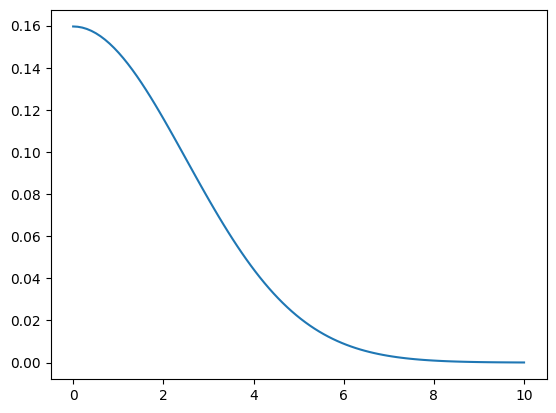

In [14]:
# partial:new f with partial application of the given arguments and keywords.
plot_func(partial(gaussian, bw=2.5))

In [15]:
# partial creates a new function with an arg passed
f = partial(gaussian, bw=2.5)
# equivalent of 
f1 = lambda x: gaussian(x, bw=2.5)
f(torch.tensor([2])), f1(torch.tensor([2]))

(tensor([0.116]), tensor([0.116]))

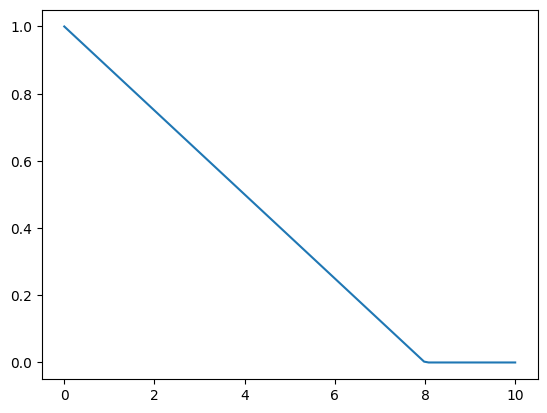

In [16]:
# the normal dist above looks a lot like tri; so we try both
def tri(d, i):
    return (-d+i).clamp_min(0)/i

plot_func(partial(tri, i=8))

In [17]:
X = data.clone() # pytorch deep copy of data
x = data[0]

In [18]:
x

tensor([29.764, 26.161])

In [19]:
# to compute distance from x to each other point in X we can take the difference
x-X # how much close is the x coord of x to the other x coords, same for y

tensor([[ 0.000,  0.000],
        [ 1.292, -4.333],
        [ 2.215,  3.030],
        ...,
        [-2.450, 21.163],
        [-1.108, 21.822],
        [ 1.417, 21.913]])

In [20]:
x.shape, X.shape
# in the difference above x is broadcasted to all the 1500 rows of X
# how? first dim is 2 for both, so ok
# second dim is not present in x, so it is treated as 1, so the 1 is broadcasted
# it creates 1500 rows of x, and each row can be subtracted to X

(torch.Size([2]), torch.Size([1500, 2]))

$$ \sqrt{ \sum_{}^{x_{dim}}((x_-X)^2)} $$

In [21]:
dist = ((x-X)**2).sum(1).sqrt()

More in general a norm is:
$$ \|\mathbf{x}\|_p := \left(\sum_{i=1}^n \left|x_i\right|^p\right)^{1/p} $$
Eg:
- rmse/L2 = euclidean norm -> pitagora distance (given 2 points-> compute hypt)
- mae/L1 = 1-norm, manhattan distance (given 2 points, sum the sides of the rectangle)

In [22]:
dist[:8]

tensor([0.000, 4.521, 3.754, 6.305, 3.483, 1.957, 4.321, 1.555])

In [23]:
x-X, (x-X).shape

(tensor([[ 0.000,  0.000],
         [ 1.292, -4.333],
         [ 2.215,  3.030],
         ...,
         [-2.450, 21.163],
         [-1.108, 21.822],
         [ 1.417, 21.913]]),
 torch.Size([1500, 2]))

In [24]:
# use einsum to do same count as above
d = torch.einsum('ik,ik->i', x-X, x-X).sqrt(); 
d[:8]

tensor([0.000, 4.521, 3.754, 6.305, 3.483, 1.957, 4.321, 1.555])

In [25]:
# now compute the weights:
weights = gaussian(dist, 2.5)
# by passing the dists values into the gaussian we get for high distances a low value
# while for small distances low values

In [26]:
weights

tensor([    0.160,     0.031,     0.052,  ...,     0.000,     0.000,     0.000])

So now we want to compute a weighted avg:
            $$ \frac{\sum_{i} w_{i}x_{i}}{\sum_{i} w_{i}} $$

In [27]:
weights.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [28]:
weights[:,None].shape

torch.Size([1500, 1])

In [29]:
weights[:,None]*X

tensor([[    4.750,     4.175],
        [    0.886,     0.948],
        [    1.424,     1.196],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [30]:
(weights[:,None]*X).sum(0)/weights.sum()

tensor([28.118, 27.619])

In [31]:
def one_update(X):
    for i, x in enumerate(X):
        # dist of x to all points (N,2)
        dist = torch.sqrt(((x-X)**2).sum(1)) #torch.einsum('ik,ik->i', x-X, x-X).sqrt()
        # weight of each distance wrt x
        weight = gaussian(dist, 2.5)
        # update x vals as weighted avg of all other data wrt its dists 
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [32]:
def meanShift(data):
    X = data.clone()
    for it in range(5):
        one_update(X)
    return X

In [33]:
%time X=meanShift(data) 

CPU times: total: 1.17 s
Wall time: 1.2 s


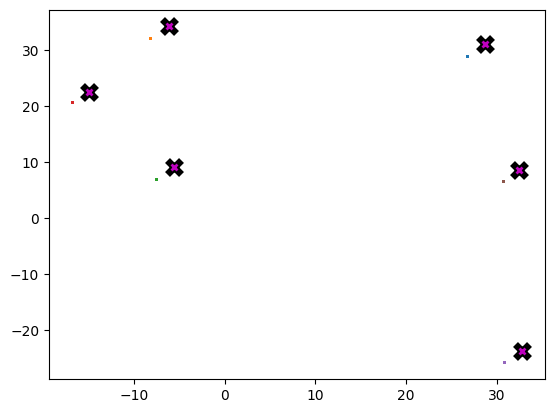

In [34]:
plot_data(centroids+2, X, n_samples) 
# centroids+2 to shift 'em to see where computed centroids are 

At each iteration what we are doing is the following:
- place ourselves on a data point, 
- compute dists wrt to all other points
- from this point pass distances into a gaussian that smooths produces weights 
with low value for high dists and high vals for low dists
- update my coords to make em similar to the values close to me

# Animations
Many of our algos are iterative so it's nice to create animations to see how things are going

In [35]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [36]:
def do_one(d): # d is frame idx, first frame just plot
    if d: one_update(X) # update data
    ax.clear() # clear plot
    plot_data(centroids+2, X, n_samples, ax=ax) # plot data

In [37]:
X = data.clone()
fig,ax = plt.subplots()
# FuncAnimation runs do_one frames=6 times (starts at 0), 
# each call has a delay of interval=500
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat= False)
plt.close()
HTML(ani.to_jshtml())

# Let's try now try to parallelize things:

one_update is a huge loop, we could cuda the contnent of the loop but it is a bad idea cuz there would be huge overhead into moving stuff to gpu back and forth: "kernel launching overhead". => no cuda code inside loop!
So we can use broadcasting to do the same counts but in chunks.
How you do so? You use batches

In [38]:
bs = 5
X = data.clone()
x = X[:bs] # first bs rows of data
# now we need to apply broadcasting to this new case

In [39]:
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [40]:
# we need to add a dimension to make these 2 broadcastable
# what happens when broadcasted?
x[None].shape,X[None].shape

(torch.Size([1, 5, 2]), torch.Size([1, 1500, 2]))

In [41]:
# the shapes above are not broadcastable! we need to carefully engeneerize the 
# broadcasting:
x[:,None,:].shape, X[None].shape

(torch.Size([5, 1, 2]), torch.Size([1, 1500, 2]))

In [42]:
# now we can subtract
batch1Dists = x[:,None,:]-X[None]; batch1Dists.shape

torch.Size([5, 1500, 2])

- broadcasting x to ([5, 1500, 2]) will create a stack of 5 matrices with 1500 rows where each row is the x_i coords

- broadcasting X to ([5, 1500, 2]) will create a stack of 5 mmatrices, all copies of the datast

Thus taking x[:bs]-X in 1 step will compute all the diffs for bs data points wrt all the data (instead of the need of looping over each x_i one at the time)

In [43]:
d = (batch1Dists**2).sum(2).sqrt()

In [44]:
d.shape

torch.Size([5, 1500])

In [45]:
weight = gaussian(d, 2.5)
weight.shape

torch.Size([5, 1500])

In [46]:
X.shape

torch.Size([1500, 2])

In [47]:
(weight[...,None] * X[None]).sum(dim=1)

tensor([[296.880, 291.612],
        [476.489, 514.066],
        [140.263, 134.432],
        [278.256, 307.251],
        [577.373, 615.003]])

In [48]:
weight.shape

torch.Size([5, 1500])

In [49]:
out = weight@X

In [50]:
out, out.shape

(tensor([[296.880, 291.612],
         [476.489, 514.066],
         [140.263, 134.432],
         [278.255, 307.251],
         [577.373, 615.003]]),
 torch.Size([5, 2]))

In [51]:
weight.sum(1), weight.sum(1)[...,None].shape

(tensor([10.558, 17.315,  5.167, 10.983, 21.347]), torch.Size([5, 1]))

In [52]:
# last step to be recreated:
# X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [53]:
weight.sum(1)[...,None]

tensor([[10.558],
        [17.315],
        [ 5.167],
        [10.983],
        [21.347]])

In [54]:
weight.sum(1, keepdim=True)

tensor([[10.558],
        [17.315],
        [ 5.167],
        [10.983],
        [21.347]])

In [55]:
out = out/weight.sum(1)[...,None]; out

tensor([[28.118, 27.619],
        [27.519, 29.689],
        [27.145, 26.016],
        [25.334, 27.974],
        [27.047, 28.810]])

In [56]:
def meanShiftBatched(data, bs):
    X = data.clone()
    meanShiftIterations = 5
    n = X.shape[0]
    for it in range(meanShiftIterations):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n)) 
            # from i=0 to either all batch (top exclusive), or n if at end of data
            x = X[s]
            batch1Dists = x[:,None,:]-X[None]
            d = (batch1Dists**2).sum(2).sqrt()
            weight = gaussian(d, 2.5)
            out = weight@X
            out = out/weight.sum(1)[...,None]
            X[s] = out
    return X

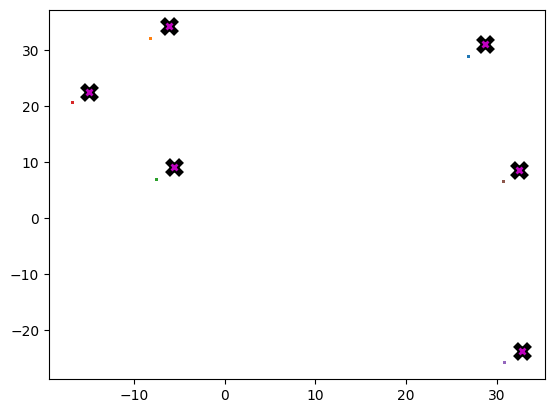

In [57]:
X_ = meanShiftBatched(data, bs=5)
plot_data(centroids+2, X_, n_samples) 

In [58]:
%time X_ = meanShiftBatched(data, bs=5)

CPU times: total: 2.77 s
Wall time: 735 ms


In [59]:
%time X_ = meanShiftBatched(data, bs=100)

CPU times: total: 891 ms
Wall time: 252 ms


In [60]:
%time X_ = meanShiftBatched(data, bs=500)

CPU times: total: 844 ms
Wall time: 254 ms


In [61]:
%time X_ = meanShiftBatched(data, bs=50)

CPU times: total: 1.11 s
Wall time: 286 ms


In [62]:
%time X_ = meanShiftBatched(data, bs=256)

CPU times: total: 750 ms
Wall time: 235 ms


In [63]:
%time X_ = meanShiftBatched(data, bs=200)

CPU times: total: 922 ms
Wall time: 253 ms


# K-means

1) sample 6 points randomly from D,
2) these will be the initial centroids
3) for each obs in D 
    - compute its distance wrt each centroid
4) update centroids of each cluster
5) repeat 3-4 untill convergence
    
Goal of the technique -> find centroids

In [64]:
from random import randrange
n_clusters = 6
randomIdxs = [randrange(1500) for _ in range(n_clusters)]
centroids_ = data[randomIdxs]
centroids_, centroids_.shape 

(tensor([[ 33.627, -27.147],
         [ -6.248,   7.518],
         [ 30.042, -27.229],
         [ 32.181, -21.390],
         [ -9.421,  31.664],
         [ 32.773, -18.890]]),
 torch.Size([6, 2]))

In [65]:
data.shape

torch.Size([1500, 2])

In [66]:
X = data.clone()

In [67]:
centroids_[:,None,:].shape

torch.Size([6, 1, 2])

In [68]:
X[None].shape

torch.Size([1, 1500, 2])

In [69]:
((centroids_[:,None,:] - X[None])**2).sum(-1).sqrt().shape

torch.Size([6, 1500])

In [70]:
d = ((centroids_[:,None,:] - X[None])**2).sum(-1).sqrt()

In [71]:
# in each col of d find min, -> that row idx is the closest centroid 
# goal: get a 6x2 matrix with updated centroids

In [72]:
# reduce on dim 0 cuz we want a row vector of 1500 els
d.min(0, keepdims=True), d.min(0, keepdims=True).indices.shape

(torch.return_types.min(
 values=tensor([[39.569, 37.911, 37.229,  ..., 23.894, 23.307, 23.558]]),
 indices=tensor([[4, 4, 1,  ..., 5, 5, 5]])),
 torch.Size([1, 1500]))

In [73]:
idxs = d.min(0, keepdims=True).indices

In [74]:
idxs

tensor([[4, 4, 1,  ..., 5, 5, 5]])

In [75]:
idx_mask = (idxs == 0)

In [76]:
idx_mask.shape, X.shape

(torch.Size([1, 1500]), torch.Size([1500, 2]))

In [77]:
selectedRows = X[idx_mask.squeeze(0)]
selectedRows.mean(0)

tensor([ 33.209, -26.868])

In [78]:
for i in range(n_clusters):
    idx_mask = (idxs == i)
    selectedRows = X[idx_mask.squeeze(0)]
    centroids_[i] = selectedRows.mean(0)

In [79]:
from random import randrange
n_clusters = 6

def kmeans(data, n_clusters, iterations = 5):
    
    X = data.clone()
    n = X.shape[0]
    
    # Randomly select centroids
    randomIdxs = [randrange(n) for _ in range(n_clusters)]
    centroids = data[randomIdxs]
    
    for it in range(iterations):
        # compute dist matrix
        d = ((centroids[:,None,:] - X[None])**2).sum(-1).sqrt()
        # get idxs of min dist per obs
        idxs = d.min(0, keepdims=True).indices
        
        # update centroids
        for i in range(n_clusters):
            idx_mask = (idxs == i)
            selectedRows = X[idx_mask.squeeze(0)]
            centroids[i] = selectedRows.mean(0)
    return centroids

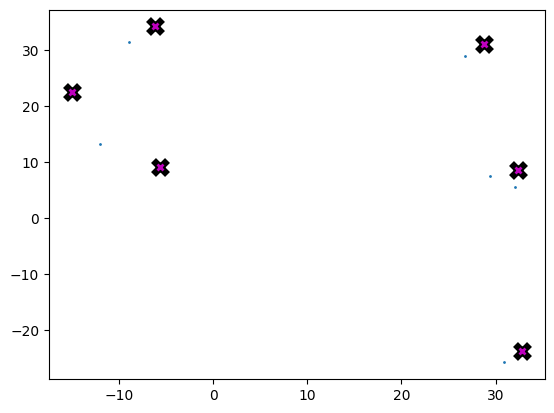

In [86]:
centroidsClustering = kmeans(data, n_clusters= 6, iterations = 5)
plot_data(centroids+2, centroidsClustering, n_samples) 